In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

import seaborn as sns

from transformers import BertTokenizerFast, AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification
from huggingface_hub import PyTorchModelHubMixin

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

from wordcloud import WordCloud

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from langchain.embeddings import HuggingFaceEmbeddings

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.functional import F

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Callback

import wandb
from copy import copy
import string
from tqdm import tqdm
import pickle

nltk.download('stopwords')
torch.set_float32_matmul_precision('medium')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yvokeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# One-time installs
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 20.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


# Introduction
The need to produce an accurate classifier which can predict if a given text is a question, concern or harmful comment came up during the conceptualizing phase of the cnlp1 Challenge "Data-Chatbot". Its goal is to produce a chatbot that can provide BSc Data Science students with relevant information about the degree program or learning plattform 'spaces'. The chatbot should also be able to identify concerns a user might have and provide an adequate answer. The authors came up with the idea to fine-tune separate LLMs for each use case in order to solve this task. Therefore, a classification of a user's input prompt is needed so to pass it to the respective model.

Three approaches for producing a suitable classifier were selected. The training and evaluation of those approaches is documented in this notebook followed by a discussion on what the best classification model is and how it could possibly be improved.

## Approaches
A classic machine learning model and at least one fine-tuned deep learning model has to be trained and evaluated in order to comply with the mini challenge 1 requirements of the module «npr». The need to include one additional model came up because the mc1 requirements were designed for groups of 2 people and our team consists of 3 members. Together with the supervisors we decided on comparing the following three approaches:

- A classic machine learning model as the baseline model (non-deep learning)
- A RNN model
- A fine tuned transformer model

## Evaluation
A set of evaluation metrics for quantitative evaluations has to be defined in order to identify the best model.  
Additionally a qualitative analysis was done to look at individual predictions to visualize possible drawbacks.    

### Quantitative evaluation
A classification model can be quantitatively evaluated when the dataset contains the correct labels. It is then possible to calculate different metrics based on the confusion matrix. The use case in this notebook requires the model to make as many correct predictions as possible without a strong preference for false positives or false negatives. Both the accuracy and the F1-Score reflect that requirement which is why they are used in the model evaluation.

#### Accuracy 
One of the most commonly used metrics for classification models is accuracy (@grandiniMetricsMultiClassClassification2020). It indicates the percentage of correctly classified samples in relation to the total number of samples. An **advantage** of accuracy is its simplicity and interpretability. The **disadvantage** is that it can be misleading for unbalanced data sets as it does not provide information about the performance of the model for individual classes.

$$
Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{\sum_{i=1}^{n} \text{True Positives}_i}{\sum_{i=1}^{n} (\text{True Positives}_i + \text{False Positives}_i + \text{False Negatives}_i)}
$$

##### F1-Score

Precision indicates the ratio of true positive predictions to the total number of positive predictions. Recall indicates the ratio of true positive predictions to the total number of actual positive predictions. A **disadvantage** of precision and recall is that precision and recall must be considered separately to get a complete picture of a model's performance. An **advantage** is that models with a metric such as precision can be optimised for specific requirements from the use case. This is advantageous, for example, if the consequences of a misclassification would be particularly severe. The F1 score is the harmonic mean of precision and recall and thus forms a metric that takes both aspects into account. 

$$
Precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

$$
Recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

$$
F1\text{-}Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

**Macro and Micro Average**

For multiclass classification problems, precision, recall and F1-score can be calculated individually for each class and then aggregated. One way to aggregate these metrics is the macro average, where the metrics are calculated individually for each class and then averaged across all classes. The micro average on the other hand calculates the metrics based on the total number of true positives, false positives and false negatives across all classes. Accordingly, this gives the metric a different meaning: macro average gives all classes the same weighting, even those with fewer samples, while micro average is more strongly influenced by the classes with more instances.

Macro Average:

$$
\text{Macro Average Precision} = \frac{1}{n}\sum_{i=1}^{n} Precision_i
$$
$$
\text{Macro Average Recall} = \frac{1}{n}\sum_{i=1}^{n} Recall_i
$$
$$
\text{Macro Average F1-Score} = \frac{1}{n}\sum_{i=1}^{n} F1\text{-}Score_i
$$

The following exploratory data analysis will show the balance of the dataset and should there be no class imbalance, then the F1 Macro Average is perfectly suitable as an evaluation metric, as this provides more robustness and no disadvantages.

### Qualitative evaluation

The result of an nlp task can be analysed qualitatively by assessing how well the prediction reflects the desired outcome. The use case described in this notebook has no need for such an evaluation, so instead a set of prompts generated by the authors is used to assess how well the model performs with prompts an actual user would query. 

# Dataset

The dataset crafted for the chatbot merges three distinct types of data to cover a range of interactions it will encounter. From the [germanquad](https://huggingface.co/datasets/deepset/germanquad) dataset, questions are selected for their relevance to general knowledge inquiries. These are paired with texts from the [germeval18](https://huggingface.co/datasets/philschmid/germeval18) dataset, which provides examples of offensive language that the chatbot must learn to recognize and reject. To add depth, the dataset includes concern-related texts, which are sourced from the [Stress-Annotated Dataset (SAD)](https://github.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD) that contains English-language entries pertaining to stressors in areas such as school and work. These entries are translated into German to align with the rest of the dataset, ensuring the chatbot receives uniform input during training. For translation, a [model](https://huggingface.co/facebook/nllb-200-distilled-1.3B) from Hugging Face is used.

The purpose of a balanced training and testing set is to create a chatbot that can handle all types of prompts equally well. By having an equal number of questions, concerns, and examples of harmful content, the chatbot is less likely to become biased. It won't over-prioritize one type of prompt over another. This balance is important because it reflects the variety of inputs a chatbot will encounter once it goes live. 

## Explorative Data Analysis

In [12]:
df_train = pd.read_parquet("../../data/train.parquet")
df_test = pd.read_parquet("../../data/test.parquet")
df_benchmark = pd.read_csv("../../data/benchmark.csv", sep=";")

### Class balance 

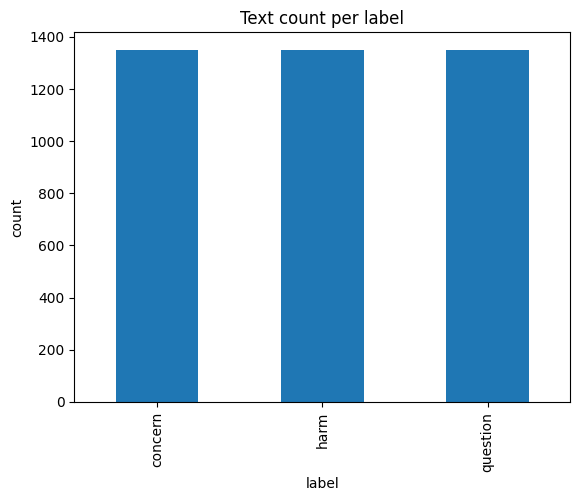

In [13]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Text count per label")
plt.show()

As we can see our script [build_dataset.py](../build_dataset.py) handled the class balancing correctly. There is no class imbalance.

### Duplicates and intersection between train and test

In [14]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  9
Duplicates in test df:  1
Intersection between train and test:  4
Length of train set:  4050
Length of test set:  1014


As we can see we have duplicates in the dataset.  
There are also some texts in the train and test dataset simultaneously.  
The amount of intersections and duplicates is low but for the sake of completeness they are removed.

In [15]:
#drop duplicates
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

#drop intersections from test set
df_test.drop(df_test[df_test.text.isin(np.intersect1d(df_train.text.values, df_test.text.values))].index, inplace=True)

In [16]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009


After removal no duplicates or intersections occured.

### Distribution of word count

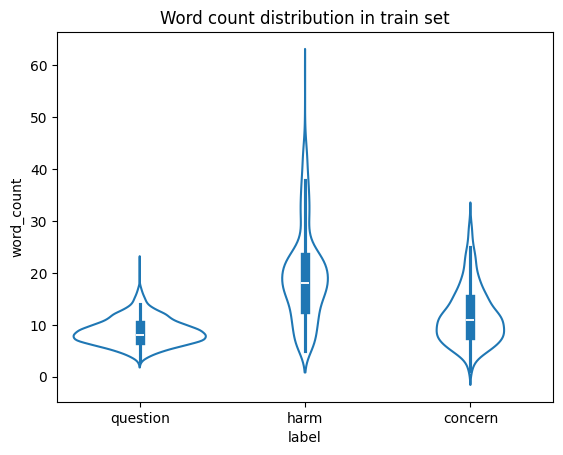

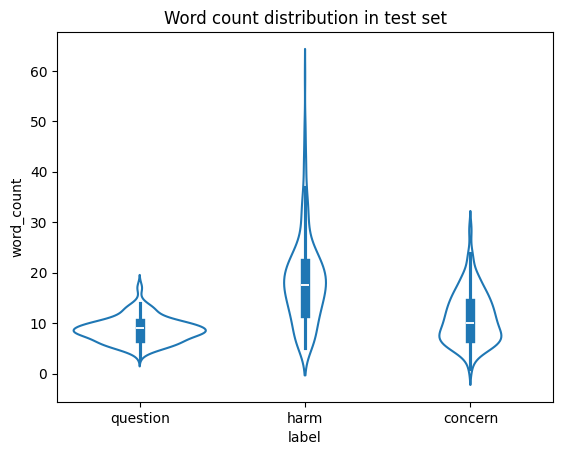

In [17]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in train set")
plt.show()

sns.violinplot(df_test.assign(word_count=df_test['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in test set")
plt.show()

In these violin plots we can see the word count distribution of the texts grouped by class.  
Harm has the longest median word count per text with a massive tail.  
Question has the smallest variance in word count compared to harm and concern.  
Word count may be have to be taken into account because the model could learn the different distributions and also guess the class because of the word or token count.  

### Qualitative 

In [18]:
for label, results_df in df_train.groupby("label"):
    print(label + ":")
    display(results_df.sample(10, random_state=4).text.to_list())

concern:


['Mein Kollege redet zu viel mit mir, kann keine Arbeit machen.',
 'Arbeit und Familie',
 'Ich muss morgen ein paar Mal aufs College, um Papierkram für mein Stipendium zu erledigen!',
 'Ich vermisse meinen Vater so sehr, dass ich in eine große Depression geraten bin, obwohl ich nicht unbedingt traurig bin.',
 'Ich bin wirklich sehr besorgt und verärgert und bekomme immer wieder widersprüchliche Informationen von meiner Familie, mit meiner Mutter, die eher optimistisch ist und meiner Schwester, die eher pessimistisch ist.',
 'Kollegen bei der Arbeit',
 'Mein Sohn zu Hause unterrichten macht mich wirklich stressig.',
 'Ich denke, die Arbeit wird stressig.',
 'Seitdem meine Mom und ich uns gestritten haben, konnte ich nicht mehr',
 'Diese Kurswahl hat mich gestresst.']

harm:


['Vasallen schweigt und kriecht weiter was ihr ja schon seit Jahren macht!',
 'Also langsam sollte jeder abchecken wer die ANTIdemokraten und INTERnationalsozialistischen Braunen sind ! Jeder mit einem Fünkchen Verstand sollte sich auf Gewalt und zwar physische in den nächsten  Jahren einstellen !',
 'Kinderpornographie wie bei der versifften SPD kommt besser?....',
 'Es sind doch nicht Flüchtlinge die kommen sondern Gesetze brechende Invasoren die zu  kein Recht auf Asyl haben. Zurück mit ihnen.',
 'Niemand hat die Türken gebraucht sondern die wurden uns von den USA nach dem Krieg aufgewzungen.',
 'Gibt es bei euch überflüssigen deutschfeindlichen Grünen nicht ein Thema wo ihr NUR etwas Ahnung vion habt?',
 'Was lese ich "Erdogan droht Europäer bald nirgendwo auf d. Welt sicher." Für mich ein Strippenzieher d. Terrors von Murksel mitfinanziert',
 'Ein Afrikaner der in China lebt oder geboren ist ist dann WAS? Africhinese. Das ist lachhaft. Es gibt nur eine Nationale Identität. Sie hän

question:


['Wieso schloss die Militärjunta in Myanmar viele Unis?',
 'Warum wird die Umstellung auf Sommerzeit von manchen Menschen kritisiert?',
 'in welchem Krieg wurde die Republik der Vereinigten Sieben Provinzen unabhängig?',
 'Welcher US-Präsident war Niederländisch-Muttersprachler?',
 'Ab wann wurde im Elsassgebiet erstmals Ackerbau betrieben?',
 'Wie dick ist Schelfeis in Antarktika?',
 'Wie wann spürt man Folgen des Erdbebens Am 7. Dezember 1988 in der Armenischen SSR? ',
 'Unter welchem US-Präsident trat die Beschränkung der Präsidentschaft auf zwei Wahlperioden in kraft?',
 'Wie können Hunde Geschmacksstoffe nur wahrnehmen?',
 'Wie viele Einwohner North Carolinas sind nicht Teil einer Religion?']

`concern:`  
The concern labels where translated from English to German.  
Sometimes the sentences are formulated in a way a normal native Speaker wouldn't say:
- 'Ich bin so müde, diese langen Stunden zu arbeiten.'
- 'Schule ist so stressig und unangenehm, dass mein Körper sich gegen sie gewöhnt hat, und nur der Gedanke daran bringt mich an den Rand eines Angstangriffs.'

The concern data is probably also not fully fitted for our usecase because sometimes the sentences are somewhat "loose" and dont fit in a conversation from a chatbot:
- 'Wir haben einen neuen Kerl am Arbeitsplatz und er hat keine Erfahrung.' -> Thats an expression a datascience student probably would't formulate

`harm:`  
For the harm data we can also see that a lot off "..." notations are used and probably the models can overfit on that.  
Those are also sentences datascience students often wouldn't formulate and thats why the harm data probably doesn't fit to our usecase for the chatbot.  
Sometimes the sentence structure or grammar is not corrent.

`question:`   
These sentences are content related questions.  
Those questions could be formulated from datascience students.  
From a qualitative aspect there is no issue with those sentences.  
But each question ends with a questionmark.  
So same possible problem as for harm with the three dots.  

### Wordcloud

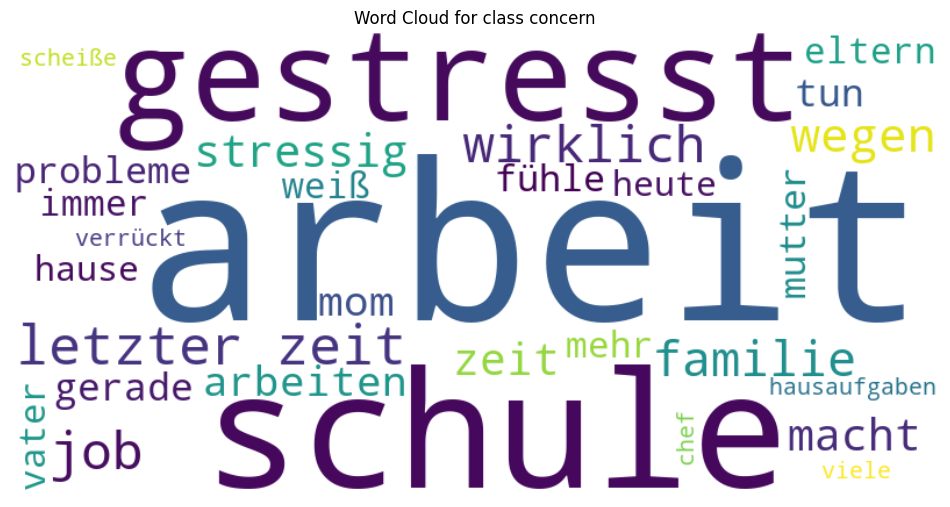

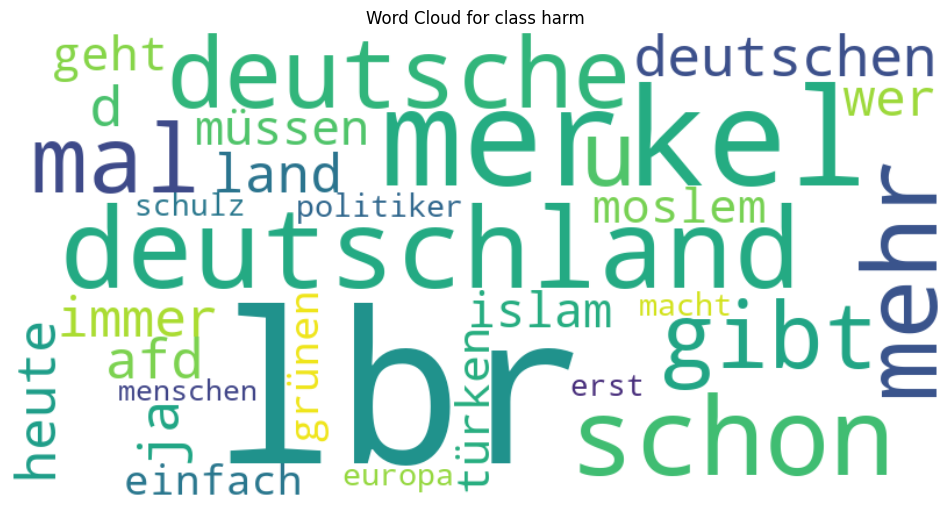

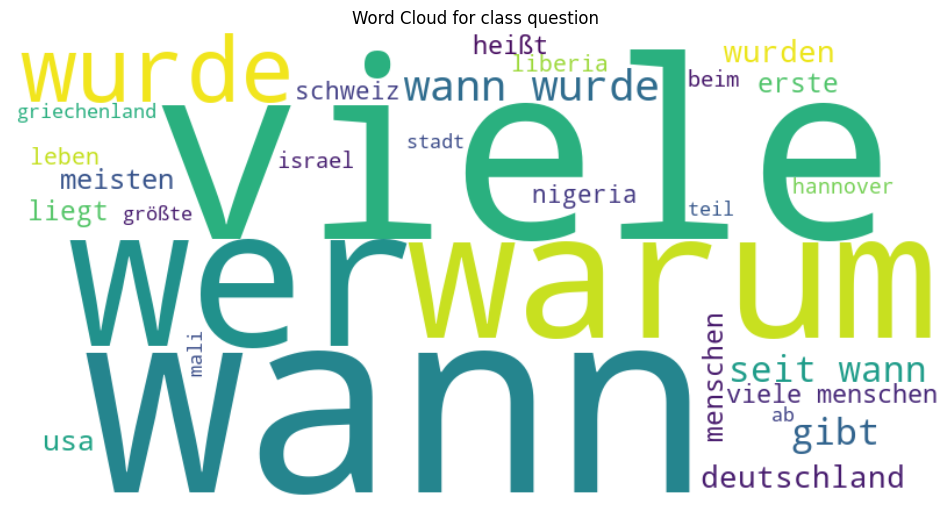

In [51]:
nlp = spacy.load("de_core_news_sm")

def generate_count_wordclouds(df:pd.DataFrame, top_n_words=30):
    # Load German stopwords
    german_stopwords = set(stopwords.words('german'))

    # create custom tokenizer that removes punctuation, spaces and non-alphabetic characters
    def spacy_tokenizer(doc):
        with nlp.disable_pipes(*["ner", "parser", "tagger"]):
            return [t for t in nlp(doc) if not t.is_punct and not t.is_space and t.lower_ not in german_stopwords]

    for label, df in df.groupby("label"):
        tokens = df.text.apply(spacy_tokenizer)
        lowercase_tokens = [token.lower_ for doc in tokens for token in doc]

        # create wordcloud
        wordcloud = WordCloud(
            width=800, height=400, background_color="white", max_words=top_n_words
        ).generate(" ".join(lowercase_tokens))

        # show wordcloud
        plt.figure(figsize=(12, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Word Cloud for class {label}')
        plt.show()


generate_count_wordclouds(df_train)

We first plotted the wordclouds for all classes including stopwords, which resulted in linking words like "aber", "und", "der", "welche" being the most common for all classes. These are not the words that the model will be able to differentiate the classes on. Therefore, we removed the stopwords and plotted the wordclouds again.

As the worldclouds show now, the words that are most common for each class are more specific to the class. For example, for the class `concern` the words "arbeit", "gestresst", "schule" are the most common. For the class `harm` the words "türken", "afd", and interestingly "deutschland" as well as "merkel" are the most common. For the class `question`, the words "viele", "wer", "warum", "wann" are the most common, which makes sense as these are question words.

### Topic modelling

In [13]:
def tsne_reduction_interactive(df: pd.DataFrame, title:str, pca_dim=50, perplexity=30, learning_rate=200, seed=1234):
    # Kopie erstellen
    df = df.copy()

    # LabelEncoder zum Konvertieren der String-Labels in numerische Werte
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(df['label'])

    # Embeddings erstellen
    embeddings = np.array(HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v1").embed_documents(df.text.to_list()))

    # Dimensionsreduktion mittels PCA
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca_result = pca.fit_transform(embeddings)

    # Anwendung von t-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=seed)
    tsne_result = tsne.fit_transform(pca_result)

    # Nur Dimension 1 und 2 auswählen
    df[["dim1", "dim2"]] = tsne_result[:, :2]

    # QDA anwenden
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(tsne_result, numeric_labels)
    qda_classes = qda.predict(tsne_result)

    # QDA-Klassen zum DataFrame hinzufügen
    df['qda_class'] = qda_classes

    # Gitternetz erstellen
    x_min, x_max = df['dim1'].min() - 1, df['dim1'].max() + 1
    y_min, y_max = df['dim2'].min() - 1, df['dim2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Gittervorhersagen treffen und Labels in numerische Werte umwandeln
    Z = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Definieren einer benutzerdefinierten Farbskala
    custom_colorscale = [
        [0, 'blue'], 
        [0.5, 'red'], 
        [1, 'green']  
    ]

    # Farbzuordnung für jede Klasse definieren
    color_map = {
        'harm': 'red',  
        'question': 'green',
        'concern': 'blue'
    }

    # Plotly-Figur erstellen
    fig = go.Figure()

    # Hintergrund (Kontur) hinzufügen
    fig.add_trace(go.Contour(
        x=np.arange(x_min, x_max, 0.1), 
        y=np.arange(y_min, y_max, 0.1),
        z=Z, 
        colorscale=custom_colorscale,  # Benutzerdefinierte Farbskala
        opacity=0.5,
        showscale=False  # Entfernt die Colorbar
    ))

    # Trennen nach Klassen und separater Marker für jede Klasse
    classes = df['label'].unique()
    for cls in classes:
        class_df = df[df['label'] == cls]
        fig.add_trace(go.Scatter(
            x=class_df['dim1'], 
            y=class_df['dim2'], 
            mode='markers',
            marker=dict(color=color_map[cls], size=10, opacity=0.8),
            name=cls,
            text=class_df['text'],
            hoverinfo='text'
        ))

    # Layout anpassen
    fig.update_layout(
        title=title,
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        width=1000, height=1000,
        margin=dict(l=40, r=40, t=40, b=40),
        legend_title='Klassen'
    )

    # Visualisierung anzeigen
    iplot(fig)

    # inverse
    df['qda_class'] = label_encoder.inverse_transform(df['qda_class'].values)

    return df

# Funktion verwenden
df_tsne = tsne_reduction_interactive(df_train, 'PCA and t-SNE reduced embeddings of train data')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In this plot we can see the first two dimensions of the t-SNE reduced embeddings.  
All the texts are represented as a dot in this plot.  
The color of the dot represents the assigned label.  
To also visualize the boundaries of the clusters also a qda is fitted to the reduced data and displayed as colored background.  
There are three clearly visible clusters which represent the labels.  
But there are also some dots which break out into the other cluster.  

In [14]:
for label, results_df in df_tsne[df_tsne.label != df_tsne.qda_class].groupby(["label", "qda_class"]):
    print(f"{label[1]} instead of {label[0]}:")
    display(results_df.text.tolist())

harm instead of concern:


['mit dem bestmöglichen Durchschnitt abschließen',
 'Sie haben gerade erkannt, dass ihre UF-Bewerbung morgen fällig ist, und sie haben noch nicht einmal mit ihren Aufsätzen für diesen Aufsatz begonnen.',
 'Und jetzt lassen sie sich plötzlich scheiden.',
 'Abigail kehrte mit einem weiteren Seufzer fort und verfluchte die Tatsache, daß sie als leitende Beamte gezwungen war, mehr zu tun.',
 'Die Verkäufe sind gesunken, keine $$$:',
 'Es gibt kaum Arbeit bei Mechanical Turk in der letzten Woche.',
 'Ich kann nicht glauben, dass meine Frau Pasta in den Chili getan hat.']

question instead of concern:


['Was zu tun ist',
 'Das Coronavirus hat mich gestresst, es hat unser Geschäft beeinträchtigt.',
 'Ich mache mir derzeit Sorgen um das Corona-Virus und meine Arbeitssicherheit.',
 'Das Coronavirus bedroht meine aktuelle Beschäftigung.',
 'Ich bin eine Hausmutter mit einem Kleinkind, diese Coronavirus-Sache macht mir Angst um sie.',
 'Diese ganze Coronavirus-Pandemie macht mich gestresst, ich habe meinen Job verloren.',
 'Das Coronavirus hat mich so finanziell belastet.',
 'Diese Coronavirus-Pandemie und all die Arbeitsplätze, die verloren gehen.',
 'Die Tatsache, dass der Coronavirus mich arbeitslos gemacht hat.',
 'Denn ihr Arbeitgeber will nicht genug Mitarbeiter einstellen, um alle Aufgaben realistisch zu übernehmen. Warum sollten sie sich also anstrengen, gute Arbeit zu leisten?',
 'Wegen des Coronavirus nicht arbeiten können',
 'Ich hatte Angst, dass ich wegen des Coronavirus meinen Job verlieren könnte.',
 'Das Coronavirus und die Sicherheit meiner Familie',
 'Das Coronavirus hat

concern instead of harm:


['Der arme... Trauma jeden Tag Sehnsucht nach Familiennachzug kein eigenes Haus...nachvollziehbar...!',
 'Wir sind nur noch von Menschen mit Gehirn Prothesen umgeben. .',
 ' bis  habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.',
 'Verzieh dich keiner interessiert sich für deine Meinung',
 'Bin total Traumatisiert Ich glaub jetzt ich bin weder Mann noch Frau. Zwitter auch nicht. Tunte oder Anal Ritter fällt auch aus. Ich bin mir sicher das ich das  Geschlecht bin..... Ich bin ein Wolperdinger.',
 'Also ich habe bei dem Herrn eine deutliche Alters Demenz gesehen.',
 'So etwas machen nur Kinder von alt er. Höcke ist kein Freund von mir. Aber solche Leute haben wir früher zurück gefickt und abgetrieben. Es giebt keine Kollektiv Schuld.',
 'Vielleicht hat sie genauso wie ich die Nase voll von Oberlehrern mit dem von Barnett angestrebten IQ .',
 'Ich kann jede Minute im Leben nur einm

question instead of harm:


['Was hat eine abgewählte deutschfeindliche SPDNull hier noch zu labern?',
 'Was ist den das fette etwas da ..?',
 'Wer schützt uns vor den Aids verseuchten Negernwerden die überhaupt untersucht ?Aber erst mal auf uns losgelassen!',
 'Schaukel als Kind zu nah an der Wand gestanden???',
 'Das habe ich mir gedacht!Es werden unheilbare Krankheiten und vor allem unbekannte Viren Im Buntland eingeschleppt !',
 'Nimmst Du Drogen oder ist es Alkohol?',
 'Wer ist dieser Almanuser überhaupt?',
 'Wie viel Oblaten muss ich denn jetzt essen bis ich ein Steak von Jesus zusammen hab?',
 'Wie dämlich müssen erst die Sesselfurzer sein wenn sie den Unterschied von  und  Jahren nicht erkennen....?',
 'Warum das Khajiit Image ?? Das hat sich einfach so ergeben wie Französische Armeen',
 'Heute wird Unwort des Jahres bekanntgegeben. Wie wärs mit Fresse Kacke oder Bätschi? ',
 'Wo werden diese Clowns nur gezüchtet und wie entsteht solch eine Gesinnung ...?',
 'Wieviel Wasser ist im Kopf von']

harm instead of question:


['Warum hat Kanye West im September 2005 die US-Regierung kritisiert?',
 'Welchen Rückschluss kann man anhand des Korruptionswahrnehmungsindex von Tadschikistan machen?',
 'Warum können Untertitel fremdsprachiger Filme nicht den vollen Informationsgehalt eines Filmes widerspiegeln?',
 'Wieso folgte Susan Rice nicht als Außenministerin nach Hillary Clinton?',
 'Wieso bezeichneten einige Republikaner Schwarzenegger als Mogelkandidat?',
 'Welche Fluggesellschaften aus Liberia dürfen in die EU fliegen? ',
 'Warum müssen die Griechen den Begriff "türkische Minderheit" vermeiden?',
 'Warum wird die Referenzdatei-Datenbank von YouTube kritisiert?']

`harm instead of concern:`  
There is no visible pattern why those text blocks are in harm instead of concern.  
Its possible that this is due to the reduced dimensions or qda is not flexible enough.

`question instead of concern:`  
If we have a look at the wrong predictions there are 14 of 20 predictions which are about the corona virus.  
The coordinates (~1.3, ~-10.7) represent this pile of points.  
This is very close to the boundary, therefore its possible that qda is not flexible enough.  
Most of the leftover wrong predictions are concern textblocks which are formulated as questions.  
So no wonder why those are classified as questions.

`concern instead of harm:`  
Here no idea why this is wrongly classified.  
There are some exceptions which I understand why its classified as concern:
- 'Der arme... Trauma jeden Tag Sehnsucht nach Familiennachzug kein eigenes Haus...nachvollziehbar...!'
- ' bis  habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.'
- 'Bin total Traumatisiert Ich glaub jetzt ich bin weder Mann noch Frau. Zwitter auch nicht. Tunte oder Anal Ritter fällt auch aus. Ich bin mir sicher das ich das  Geschlecht bin..... Ich bin ein Wolperdinger.'

`question instead of harm:`  
Here I can understand why its classified wrong.  
All the sentences are formulated as questions.

`harm instead of question:`  
Most of the textblocks contain a "foreign" counts compared to germany.  
Probably its classified wrong because in harm there are many xenophobic sentences.

# Approach #1: TF-IDF / SVM
A method that transforms text to numerical vectors has to be applied before the given document can be passed onto a classification model. One way of representing text as vectors is TF-IDF which is an extension of the simple bag-of-words model. The bag-of-words model represents a document by one hot encoded occurrence of a word/token in a document. One problem with this representation is that every word/token is treated as equally important so that frequent words with little meaning will skew the data. 
This can be improved by using TF-IDF.  
TF stands for term frequency and is calculated as follows:
$$
\mathrm{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}
$$
- $t$: term
- $d$: document
- $f_{t,d}$: raw count of term in document

IDF represents the inverse document frequency, a measure that indicates how much information a word provides:
$$
\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}
$$
- $N$: the total number of documents in the corpus
- $\{d \in D: t \in d\}|$: number of documents where the term $t$ appears in

This TF-IDF score is calculated for every word/token in a document which yields the desired vector representation of the document. Such a vector representation can then be used to train and evaluate a classificator.

## Model Selection
Different classification model architectures can be considered to solve the prediction task at hand. A selection of suitable models has been defined in the `vanilla-classification.ipynb` notebook. These models were then trained and evaluated in the same notebook. The experiments showed that a `LinearSVC` model from the `sklearn` library yields the highest performance for the given data. 

## Model Architecture
The `LinearSVC` class is an implementation of a support vector machine. This algorithm uses a kernel function to calculate the relationship between the input vectors in higher dimensions in order to find a soft margin that separates the data so that the loss function (`LinearSVC` uses squared hinge per default) is minimal.  
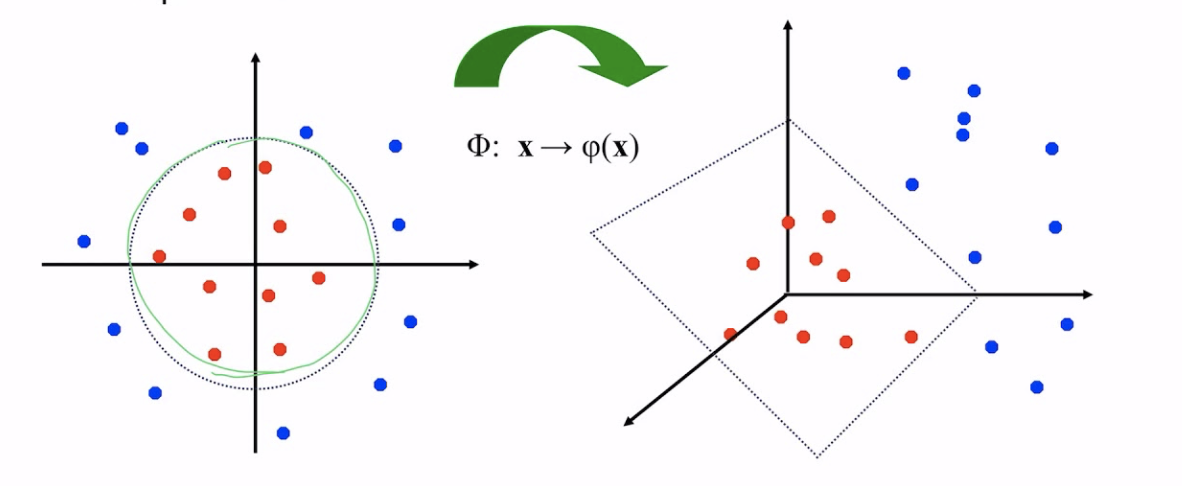

### Drawbacks
The soft margin is found using five-fold cross-validation which is expensive. Also overfitting can become an issue when the number of features is much greater than the number of samples.  

### Advantages
It is however effective in high dimensional space and versatile since dfiferent kernel functions can be defined. 

## Why we chose this architecture
By comparing the performance on the same task of 7 different classifier architectures we found that the `LinearSVC` model performed with the highest accuracy. The task to classify a text into question, harm and concern is not trivial since a document that has the syntax of a question can be a concern. It then depends more on the words used to formulate the question to identify the correct classification. This dependency can (at least partly) be captured with the TF-IDF method. How exactly this vector then relates to the target variable is hard to define but given that the support vector machine looks for relations in high dimensions, a suitable low cost decision boundry might be found where other classifiers, that do not operate in higher dimensions, might not find one. 

In [15]:
# helper functions
def lemma_tokenizer(doc):
    unwanted_pipes = ["ner", "parser", "tagger"]
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space]
    
def model_evaluation(y_val, y_pred, labels):
    # print clafficiation report
    print("\t\t\t\tCLASSIFICATIION METRICS\n")
    print(classification_report(y_val, y_pred, target_names=labels))

    # plot confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("CONFUSION MATRIX\n", size=16)

## Preprocessing & Feature Extraction / Selection
Different combinations and methods of text preprocessing have been evaluated in the `vanilla-classification.ipynb` notebook given the classification task described here. We found that the following pipeline yields the best performance for the TF-IDF/SVM architecture:
- SpaCy tokeniser returning the lemma of each token leaving stopwords in and removing punctuation
- TF-IDF vector evaluated on those tokens
- PCA to reduce the dimensionality of the resulting vector

In [16]:
# TF-IDF vectorizer with lemma tokenizer
vectorizer = TfidfVectorizer(tokenizer=lemma_tokenizer)

# PCA to reduce dimensionality to 95% variance
pca = PCA(n_components=0.95)

# fit vectorizer and pca on train set and transform train set
X_train = pca.fit_transform(vectorizer.fit_transform(df_train.text).toarray())
# transform test set
X_val = pca.transform(vectorizer.transform(df_test.text).toarray())

# define target variables
y_train = df_train.label
y_val = df_test.label

# persist vectorizer and pca
with open("svc_model/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("svc_model/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

/opt/homebrew/Caskroom/miniforge/base/envs/dependencyhell/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



## Model fitting & evaluation
After the preprocessing of the data, the model is fitted on the training dataset.

In [17]:
# fit LinearSVC model to predict y values of X_val
model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

/opt/homebrew/Caskroom/miniforge/base/envs/dependencyhell/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     concern       0.98      0.96      0.97       333
        harm       0.97      0.94      0.96       338
    question       0.96      1.00      0.98       338

    accuracy                           0.97      1009
   macro avg       0.97      0.97      0.97      1009
weighted avg       0.97      0.97      0.97      1009



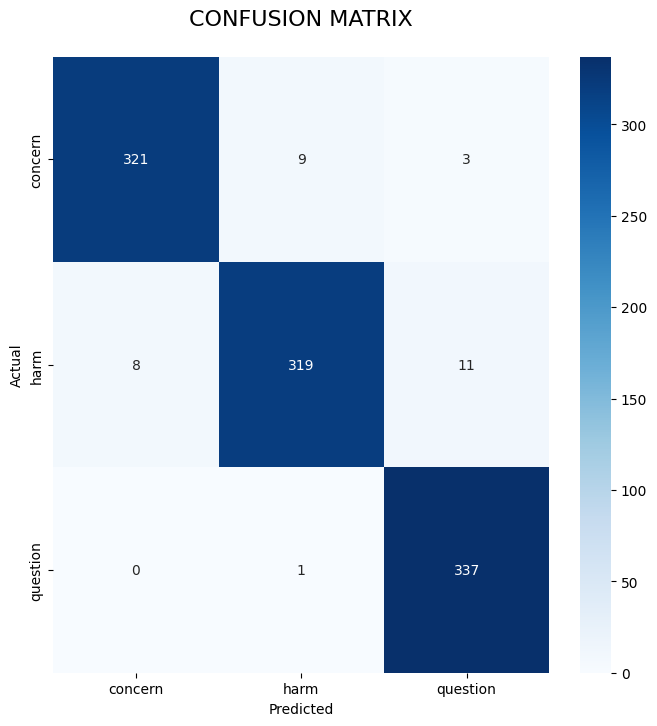

In [20]:
model_evaluation(y_val, y_pred, model.classes_)

The above plot shows the confusion matrix of the predictions for the validation dataset made by the model trained on the train dataset. The most misclassifications happen for the label harm. Only one wrong prediction is made for datapoints of the label question and several more for observations of the type concern. The model achieves an accuracy of 0.97 and a macro f1-score of also 0.97.

## Hyperparameter tuning
The following section concerns the tuning of hyperparameters in an attempt to improve the model even further.

In [12]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# define parameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],
    "loss": ["hinge", "squared_hinge"],
    "max_iter": [1000, 2000, 3000],
} 

# define grid search
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=-1, scoring="accuracy")

# fit grid search on train set
grid_search.fit(X_train, y_train)

# print best parameters
print("Die besten gefundenen Parameter für das LinearSVC Modell sind die folgenden:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5] END ..C=0.1, loss=hinge, max_iter=1000;, score=0.943 total time=   1.2s
[CV 4/5] END ..C=0.1, loss=hinge, max_iter=1000;, score=0.931 total time=   1.2s
[CV 1/5] END ..C=0.1, loss=hinge, max_iter=1000;, score=0.926 total time=   1.3s
[CV 2/5] END ..C=0.1, loss=hinge, max_iter=1000;, score=0.927 total time=   1.3s
[CV 1/5] END ..C=0.1, loss=hinge, max_iter=2000;, score=0.926 total time=   1.1s
[CV 2/5] END ..C=0.1, loss=hinge, max_iter=2000;, score=0.927 total time=   1.2s
[CV 3/5] END ..C=0.1, loss=hinge, max_iter=2000;, score=0.944 total time=   1.3s
[CV 5/5] END ..C=0.1, loss=hinge, max_iter=1000;, score=0.928 total time=   1.4s
[CV 4/5] END ..C=0.1, loss=hinge, max_iter=2000;, score=0.931 total time=   1.3s
[CV 1/5] END ..C=0.1, loss=hinge, max_iter=3000;, score=0.926 total time=   1.2s
[CV 2/5] END ..C=0.1, loss=hinge, max_iter=3000;, score=0.927 total time=   1.1s
[CV 5/5] END ..C=0.1, loss=hinge, max_iter=2000

A 5 fold cross-validation is used to evaluate the best combination of parameters given the parameter grid defined in the code block above. The result of this evaluation shows, that the best performance (scored by accuracy) is with the default values of `C=1`, `squared_hinge` as loss and `max_iter=1000`.  

In [13]:
print("The best accuracy score achieved by the grid search is: ", grid_search.best_score_)

0.9656790123456791

In [ ]:
y_pred = grid_search.predict(X_val)

In [16]:
# print number of wrong predictions
print("The number of wrongly predicted labels is:", (y_val != y_pred).sum())

text     32
label    32
dtype: int64

In [66]:
# train and persist best model
gs_best_model = LinearSVC(C=1, loss="squared_hinge", max_iter=1000)
gs_best_model.fit(X_train, y_train)

# save model params
filename = 'svc_model/model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gs_best_model, file)

/opt/homebrew/Caskroom/miniforge/base/envs/dependencyhell/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



In [18]:
# print wrong predictions with text, actual and predicted label
for text, actual, predicted in zip(df_test[df_test.label != y_pred].text, df_test[df_test.label != y_pred].label, y_pred[df_test.label != y_pred]):
    print(f"Text: {text}\nActual: {actual}\nPredicted: {predicted}\n")

Text: Als was ließ Maria de Medici den Palais du Luxmebourg bauen?
Actual: question
Predicted: harm

Text: Was hast du gegen Asiaten du Halbnigger?!
Actual: harm
Predicted: question

Text: Was für eine ekelhafte Person....der alte..!!
Actual: harm
Predicted: question

Text: Was tun mit solchen Leuten..?...wie geht man mit Unkraut nochmals um?
Actual: harm
Predicted: question

Text: Helene Fischer ist wie Bumsen mit Kondom.... Macht einfach kein Spass 
Actual: harm
Predicted: question

Text: War auch mein erster Gedanke !! Verdammte RaserOhneInnen !
Actual: harm
Predicted: concern

Text: Ich frage mich täglich was man den Leuten ins Essen getan hat dass sie so dumm und naiv geworden sind....
Actual: harm
Predicted: concern

Text: Machtverlust Unfassbar mit welchen Methoden sich nun dieses rotschwarze Dreckspack in Österreich prügelt ...
Actual: harm
Predicted: question

Text: Es gibt wichtigeres wie z.B Asylantenterror!
Actual: harm
Predicted: question

Text: Es ist zum Kotzen seit Tage

## Results
The model achieves a good performance on the validation dataset with an accuracy and macro f1-score of 0.97. One way to improve the model might be to add more documents with relevant keywords to the dataset.

# Approach #2: LSTM
In this approach we use the predecessor of the transformer architecture, the RNN, or to be more specific, an LSTM.
Since text is sequential data and RNNs are designed to operate on sequences, an LSTM should be able to classify the text.

## Model Architecture

<img src="../assets/lstm.png" width="1000">

1. Tokenization using an auto tokenizer from HuggingFace.
2. Token embeddings are taken (weight matrix of a pretrained model from HuggingFace).
3. Tokens are processed through a Conv1D. Padding is "same".
4. Output is fed into an LSTM.
5. Global average pooling of the complete LSTM output.
6. Feeding through a dense layer.
7. Softmax.

## Why we chose this architecture
This architecture uses an CNN-LSTM combination for classifying text.  
The CNN is suited for feature extraction whearas an LSTM can learn patterns over sequences, or in our case, tokens.  
Since we probably don't have enough data to learn semantic meaning from scratch, we use pretrained embeddings from a model which was trained on a much bigger dataset.

Following descriptions show the thought behind each component:

1. **Tokenization with an Auto Tokenizer**: Using an auto tokenizer from HuggingFace allows for efficient and effective state of the art tokenization.

2. **Token Embeddings from Pretrained Weight Matrix**: Using pretrained embeddings means each token is represented by a vector that encapsulates its semantic meaning, learned from large-scale language models. These embeddings capture context and relationships between words, providing a rich representation of the text.

3. **Conv1D with 'Same' Padding**: A 1D convolution layer (Conv1D) is adept at extracting local and positionally relevant features from the sequence of embeddings. Each filter can learn to detect specific n-grams.

4. **LSTM Layer**: LSTMs are a type of recurrent neural network (RNN) particularly effective in processing sequences (like text). They can capture long-term dependencies and relationships in the data, which is crucial for understanding the overall meaning and context of the text, a key factor in accurate classification.

5. **Global Average Pooling of LSTM Output**: Global average pooling reduces the output of the LSTM layer to a fixed-size vector, summarizing the important features throughout the sequence. We could also only classify the sequence based on the last output of the LSTM, but this could be problematic because the LSTM probably doesn't encode all the context into this vector (forgetting). That is why we choose a pooling over all the outputs $h_t$ of the LSTM. Another possibility would be a combination with attention as described [here](https://medium.com/@vishwajeetkumar_85368/news-classification-using-bidirectional-lstm-and-attention-a67aa803ca74).

6. **Dense Layer**: This last layer reduces the dimensionality of the pooling output to 3 dimensions.

7. **Softmax Layer**: Finally, a softmax layer is used for the actual classification. It outputs probabilities for each class, with the sum of probabilities equaling 1. This makes it easier to interpret the output as confidence scores for each class.

Overall, this architecture leverages the strengths of convolutional layers for feature extraction, LSTMs for capturing sequential and contextual information, and pooling and dense layers for summarization and classification.  
The use of pretrained embeddings accelerates learning and improves performance, particularly in cases where the available training data for the specific task might be limited.  
In cases of very long text it is still possible that the LSTM 'forgets' the text at the beginning which is a possible drawback in this architecture.

In [24]:
def load_data():
    print("loading and preprocessing datasets...")

    df_train = pd.read_parquet("../../data/train.parquet")
    df_test = pd.read_parquet("../../data/test.parquet")

    #drop duplicates
    df_train.drop_duplicates(inplace=True)
    df_test.drop_duplicates(inplace=True)

    #drop intersections from test set
    df_test.drop(df_test[df_test.text.isin(np.intersect1d(df_train.text.values, df_test.text.values))].index, inplace=True)

    print("Duplicates in train df: ", df_train.text.duplicated().sum())
    print("Duplicates in test df: ", df_test.text.duplicated().sum())

    print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
    print("Length of train set: ", len(df_train))
    print("Length of test set: ", len(df_test))

    return df_train, df_test

def prepare_loaders(df_train:pd.DataFrame, df_test:pd.DataFrame, tokenizer:str, train_batch_size:int, max_token_length:int=256, train_val_split_ratio:float=0.8, seed:int=1234, remove_train_punctuation:bool=False):
    #remove punctuation on train set if requested
    if remove_train_punctuation:
        df_train = df_train.copy()

        df_train["text"] = df_train.text.str.replace(r'[^\w\s]', '', regex=True)

    df_train, df_val = TextClassificationDataset.stratified_random_sampling(df_train, train_val_split_ratio, "label", seed)

    #Dataset and loader
    train_set = TextClassificationDataset(df_train, tokenizer, max_length=max_token_length)
    val_set = train_set.dataset_from_self(df_val)
    test_set = train_set.dataset_from_self(df_test)
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set))
    test_loader = DataLoader(test_set, batch_size=len(test_set))

    return train_loader, val_loader, test_loader, train_set.label_encoder.classes_

def train():
    wandb.init()

    PARAMS:dict = wandb.config

    df_train, df_test = load_data() #load and preprocess data
    train_loader, val_loader, test_loader, classes = prepare_loaders(
        df_train, 
        df_test, 
        PARAMS["embedding_source"], 
        PARAMS["train_batch_size"], 
        PARAMS["max_token_length"], 
        PARAMS["train_val_split_ratio"], 
        PARAMS["val_split_seed"],
        PARAMS["remove_train_punctuation"]
    ) #prepare dataloaders

    PARAMS["classes"] = classes #add classes to params

    model = CNNLSTMModel(**PARAMS) #get model
    logger = WandbLogger(entity="t_buess", project="chatbot-classification", log_model=True)
    logger.watch(model, log="all")

    #callbacks
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, mode="min")
    conf_matrix_callback = ChartLogger()

    trainer = Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=5, max_epochs=PARAMS["max_epochs"], callbacks=[early_stop_callback, conf_matrix_callback])
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopping callback and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss": best_val_loss}) #log best validation loss

    wandb.finish()

class TextClassificationDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, tokenizer:str, text_col:str="text", label_col:str="label", max_length:int=128):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer) #load and store tokenizer
        self.data = dataframe #copy dataframe
        self.max_length = max_length #max token count
        self.text_col = text_col #store text col
        self.label_col = label_col #store label col
        self.label_encoder = LabelEncoder().fit(self.data[self.label_col]) #create and fit label encoder

        self.encode_labels()
        self.tokenize_text()
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()} #get respective entry from input_ids, token_type_ids, attention_mask
        item['labels'] = self.labels[idx] #add label
        return item

    def __len__(self):
        return len(self.labels)

    def tokenize_text(self):
        #tokenize text
        self.encodings = self.tokenizer(
            list(self.data[self.text_col]), 
            truncation=True, 
            padding=True, 
            max_length=self.max_length, 
            return_tensors="pt",
            add_special_tokens=False, #remove special tokens
        )

    def encode_labels(self):
        #encode labels
        self.labels = torch.tensor(self.label_encoder.transform(self.data[self.label_col]))

    def dataset_from_self(self, dataframe:pd.DataFrame):
        copy_dataset = copy(self) #create a copy of itself

        copy_dataset.data = dataframe #override data
        copy_dataset.tokenize_text() #tokenize new text
        copy_dataset.encode_labels() #encode new labels

        return copy_dataset

    @staticmethod
    def stratified_random_sampling(dataframe:pd.DataFrame, train_size:float, ref_col:str, seed:int=None):
        # Stellen Sie sicher, dass train_size einen gültigen Wert hat
        if not 0 < train_size < 1:
            raise ValueError("train_size must be between 0 and 1")
        
        # Gruppieren des DataFrames nach der Referenzspalte und Anwenden der Sample-Methode auf jede Gruppe, Entfernen der zusätzlichen Indexebene, die durch groupby erzeugt wird
        train_df = dataframe.groupby(ref_col).apply(lambda x: x.sample(frac=train_size, random_state=seed)).reset_index(ref_col, drop=True, inplace=False)
        
        # Finden der Indexe, die nicht in der Trainingsstichprobe ausgewählt wurden
        val_idx = dataframe.index.difference(train_df.index)
        
        # Erstellen des Validierungs-DataFrames
        val_df = dataframe.loc[val_idx]
        
        return (train_df.reset_index(drop=True, inplace=False), val_df.reset_index(drop=True, inplace=False))

class CNNLSTMModel(pl.LightningModule):    
    def __init__(self, embedding_source, num_filters:int, kernel_size:int, hidden_size:int, classes:list, learning_rate:float, embedding_size:int=None, **kwargs):
        super().__init__()

        self.learning_rate = learning_rate
        self.classes = classes

        # Prüfen, ob embedding_source ein String ist, d.h. der Name eines vorab trainierten Modells
        if isinstance(embedding_source, str):
            model = AutoModel.from_pretrained(embedding_source)
            pretrained_embedding_weight = model.embeddings.word_embeddings.weight

            #create embedding layer
            self.embedding = nn.Embedding(num_embeddings=pretrained_embedding_weight.size(0), embedding_dim=pretrained_embedding_weight.size(1))
            
            # Ersetzen Sie die Gewichte des Embedding-Layers mit den vortrainierten Gewichten
            self.embedding.weight = nn.Parameter(pretrained_embedding_weight)

            # Freeze the pretrained embedding layer
            self.embedding.weight.requires_grad = False

            #override existing embedding size so its displayed correctly in wandb
            embedding_size = self.embedding.embedding_dim

        elif isinstance(embedding_source, int):
            self.embedding = nn.Embedding(num_embeddings=embedding_source, embedding_dim=embedding_size)
        else:
            raise Exception("embedding_source must be from type str or int")

        # Restliche Modellarchitektur
        self.conv1d = nn.Conv1d(in_channels=embedding_size, out_channels=num_filters, kernel_size=kernel_size, padding="same")
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, batch_first=True)
        self.dense = nn.Linear(in_features=hidden_size, out_features=len(self.classes))

        self.save_hyperparameters()

    def forward(self, x, attention_mask=None):
        x = self.embedding(x) #embed tokens
        x = x.permute(0, 2, 1) #change order of dimensions for conv
        x = self.conv1d(x) #apply conv
        x = F.leaky_relu(x) #apply non linearity
        x = x.permute(0, 2, 1) #change order for lstm

        #prepare x for lstm if attention_mask != None
        if attention_mask is not None:
            # calculate the length of each sequence in the batch
            seq_lengths = attention_mask.sum(dim=1)
            # pack the sequences
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
            
        x, _ = self.lstm(x) #apply lstm

        #if packed sequence -> unpack
        if attention_mask is not None:
            x, seq_lengths = pad_packed_sequence(x, batch_first=True) # unpack sequence
            seq_lengths = seq_lengths.unsqueeze(-1).to(x.device) #reshape

            x = torch.sum(x, dim=1) / seq_lengths # global average pooling

        else:
            x = torch.mean(x, dim=1)  # global average pooling

        x = self.dense(x) #final dense layer

        return x #return logits
 
    def training_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self.forward(inputs, attention_mask)

        loss = F.cross_entropy(logits, targets)
        
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_macro', f1_macro, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        probas = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1_macro', f1_macro, prog_bar=True)

        return {"preds": preds, "probas": probas}

    def predict(self, text:str, tokenizer:BertTokenizerFast, max_token_length:int=512):
        tokenized = tokenizer(
            [text],
            truncation=True,
            padding=False,
            max_length=max_token_length,
            return_tensors="pt",
            add_special_tokens=False #remove special tokens

        )['input_ids'].to(self.device) #tokenize text and send to device

        with torch.no_grad():
            self.eval()
            pred = self(tokenized, None).argmax(dim=1)[0] #predict class

        return self.classes[pred] #map number to label
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

class ChartLogger(pl.Callback):
    def __init__(self) -> None:
        super().__init__()

        self.preds = []
        self.probas = []
        self.targets = []

    def on_test_batch_end(self, trainer, pl_module:CNNLSTMModel, outputs, batch, batch_idx) -> None:
        preds = outputs["preds"]
        probas = outputs["probas"]
        targets = batch['labels']

        self.preds.extend(preds.cpu().tolist())
        self.probas.extend(probas.cpu().tolist())
        self.targets.extend(targets.cpu().tolist())

    def on_test_epoch_end(self, trainer, pl_module:CNNLSTMModel):
        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=self.preds, y_true=self.targets, class_names=pl_module.classes)
        })

        # Log the roc curve
        wandb.log({"roc_curve": wandb.plot.roc_curve(
            y_probas=self.probas, y_true=self.targets, labels=pl_module.classes)
        })

        # log the model
        torch.onnx.export(pl_module, torch.tensor([[1]]).to(pl_module.device), os.path.join(wandb.run.dir, "model.onnx"), input_names=["features"], output_names=["output"])
        wandb.save('model.onnx')

        # Clear for the next epoch
        self.preds = []
        self.probas = []
        self.targets = []

## Training / Hyperparameter tuning

During model training the following steps are executed:
1. loading data (`train.parquet`, `test.parquet`)
2. preparing dataloaders (splitting `train.parquet` in a train and validation dataset)
3. create model, logger and callbacks
4. Train model until early stopping or `max_epochs` reached
5. Test model

We use the embeddings and also tokenizer from the model `dbmdz/bert-base-german-cased` since this BERT model/tokenizer was trained on 2.35 billion tokens of german text.

During a training several metrics like `train_loss`, `val_loss`, `val_acc`, `val_f1_macro`, `test_loss`, `test_acc`, `test_f1_macro` are logged and uploaded to WandB.

To find the best hyperparameters a grid-search was executed.  
We identify the best configuration by looking for the model with the lowest validation_loss.  
We executed the gridsearch without cross validation due to compute time reasons.

We to the same sweep twice once without punctuation on training data and once with (its in the same sweep) to figure out if punctuation makes a difference.

In [ ]:
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "test sweep",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters": {
        "embedding_source": {"values": ["dbmdz/bert-base-german-cased"]},
        "num_filters": {"values": [128, 256, 512]},
        "kernel_size": {"values": [3,5,7]},
        "hidden_size": {"values": [64, 128, 256]},
        "learning_rate": {"values": [1e-5]},
        "train_batch_size": {"values": [32]},
        "max_token_length": {"values": [128]},
        "train_val_split_ratio": {"values": [0.8]},
        "val_split_seed": {"values": [1234]},
        "remove_train_punctuation": {"values": [False, True]},
        "max_epochs": {"values": [200]}
    }
}

sweep_id = wandb.sweep(sweep_config, entity="t_buess", project="chatbot-classification")
wandb.agent(sweep_id, train)

## Best model (with punctuation)

We have some concerns about the model overfitting on class specific punctuation as mentioned in the EDA part.  
So we will evaluate the best model trained on the dataset with and without punctuation.

The best model has the following configuration:
- `hidden_size`: 64
- `kernel_size`: 7
- `num_filters`: 512

In [8]:
_, df_test_punctpred = load_data() #load test dataset

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification/model-3xd2a0fp:v0").download()
model = CNNLSTMModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

df_test_punctpred["prediction"] = [model.predict(text, tokenizer) for text in df_test_punctpred.text]

print("Accuracy on test set: ", balanced_accuracy_score(df_test_punctpred.label.values, df_test_punctpred.prediction.values))
print("F1-Macro on test set: ", f1_score(df_test_punctpred.label.values, df_test_punctpred.prediction.values, average="macro"))

loading and preprocessing datasets...
Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Downloading large artifact model-3xd2a0fp:v0, 124.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Accuracy on test set:  0.978126055049132
F1 macro on test set:  0.9781932147968974


As we can see, we are able to reach a high F1 and Accuracy on the test set.

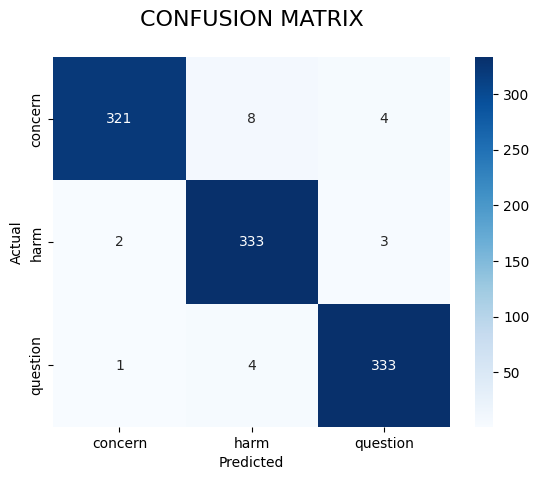

In [9]:
# plot confusion matrix
conf_mat = confusion_matrix(df_test_punctpred.label.values, df_test_punctpred.prediction.values, labels=model.classes)
sns.heatmap(
    conf_mat,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=model.classes,
    yticklabels=model.classes,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX\n", size=16)
plt.show()

If we have a look on the confusion matrix, we can see that most predictions are correct. Relative to the other classes, the model struggles most with the class `concern`.

## Best model (without punctuation)

The best model has following configuration:
- `hidden_size`: 256
- `kernel_size`: 3
- `num_filters`: 128

We can see that the model without punctuation performed the best with a lower filter count but higher hidden_size compared to the model with punctuation.  
One can hypothesize that the model with punctuaton could learn just the areas with punctuation and make a prediction based on that.  
-> Investigate further if enough time at the end of the semester

In [10]:
_, df_test_nopunctpred = load_data() #load test dataset

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification/model-6ht9s03l:v0").download()
model = CNNLSTMModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

df_test_nopunctpred["prediction"] = [model.predict(text, tokenizer) for text in df_test_nopunctpred.text]

print("Accuracy on test set: ", balanced_accuracy_score(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values))
print("F1-Macro on test set: ", f1_score(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values, average="macro"))

loading and preprocessing datasets...
Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009


wandb: Downloading large artifact model-6ht9s03l:v0, 99.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Accuracy on test set:  0.9592847285154976
F1 macro on test set:  0.9592784173269192


Without punctuation, we still have a high score both for F1 and Accuracy.  
But with around 95% it is a little less than for the model with punctuation.  

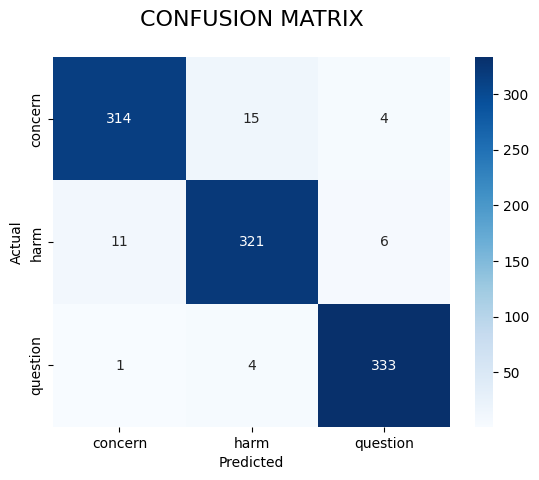

In [11]:
# plot confusion matrix
conf_mat = confusion_matrix(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values, labels=model.classes)
sns.heatmap(
    conf_mat,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=model.classes,
    yticklabels=model.classes,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX\n", size=16)
plt.show()

If we have a look at the confusion matrix we can observe that the model has more problems predicting labels of `harm` and `concern`.  
Only the true label `question` had the same performance on its predictions as with our best model with punctuation.

## Difference in prediction between model with and without punctuation

In [12]:
_, df_test_diff = load_data()

df_test_diff["prediction_punct"] = df_test_punctpred.prediction
df_test_diff["prediction_nopunct"] = df_test_nopunctpred.prediction

for group, results_df in df_test_diff[(df_test_diff.prediction_punct != df_test_diff.label) | (df_test_diff.prediction_nopunct != df_test_diff.label)].groupby("label"):
    print("actual class: ", group)
    display(results_df)

loading and preprocessing datasets...
Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009
actual class:  concern


,text,label,prediction_punct,prediction_nopunct
694,"Was machen sie in der Schule, wenn sie hier so...",concern,question,question
696,"STRESSIV Ich bin über Schule, Freunde, Eltern ...",concern,concern,harm
701,Wie man sich während der Pandemie einen langfr...,concern,question,question
711,Der Stiefsohn ist wieder aufgeregt.,concern,harm,concern
713,"Wir gingen zu Robins, zu den lang verlorenen G...",concern,concern,harm
717,Meine Mom wird so nervös und schlammig während...,concern,concern,harm
719,Klassen,concern,harm,concern
727,Mein egoistischer Kollege ist ausgelaugt...,concern,harm,concern
735,Fristen,concern,question,question
744,nicht in die Graduiertenschule kommen.,concern,harm,harm


actual class:  harm


,text,label,prediction_punct,prediction_nopunct
339,sind geklaut von uns ich hasse dieses Bauern...,harm,harm,concern
350,Was hast du gegen Asiaten du Halbnigger?!,harm,question,question
392,War auch mein erster Gedanke !! Verdammte Rase...,harm,harm,concern
396,Unterkunft normales Essen und Trinken! Schluss...,harm,harm,concern
406,Ich frage mich täglich was man den Leuten ins ...,harm,harm,concern
412,Sie ist lieb als Mutter. Sonst aber taugt ihre...,harm,harm,concern
441,Was soll man schon von so einer Lügenbande erw...,harm,harm,question
462,Es ist zum Kotzen seit Tagen!,harm,harm,concern
503,Was nun?Was soll die AfD an die Wand fahren un...,harm,harm,question
508,Ich könnte kotzen wenn ich daran denke dass wi...,harm,harm,concern


actual class:  question


,text,label,prediction_punct,prediction_nopunct
10,An was forscht die Bill und Melinda Gates Foun...,question,harm,question
122,Die Gliederwürmer sind Untergruppe von was?,question,harm,harm
172,Wie empfinden die Deutschen das Wort „Artenvie...,question,question,harm
269,Welche Arbeit hat Feynman in Princeton 1941 ge...,question,question,concern
327,An wem sollte sich laut Johann Gottsched die n...,question,harm,question
333,Nenne Vor und Nachteile von Flughäfen in der S...,question,concern,harm
334,Was für einen höhen Unterschied hat die Andert...,question,harm,harm


All observations where one of the models had a wrong prediction were plotted to compare the results.  

`actual class question:`  
As we have seen in both of the confusion matrices the row with the true label `question` has the same numbers in it.  
If we have a look at the table we can see that the predictions are actually different.  
Possibly the models also overfitted on individual words like "Arbeit" for `concern` or "Bill Gates" for `harm`.

`actual class harm:`  
The predictions for `harm` definitely got worse compared to the model with punctuation.  
The model without punctuation made the exact same mistakes as the model with punctuation except for one.  
The model without punctuation often confuses `harm` with `concern`. 
Sometimes the models predicted `question` for sentences formulated as question.  

`actual class concern:`  
There the model without punctuation also got worse if we have a look at the number of wrong predictions.  
Suspicious is the fact that all the predictions the model with punctuation correctly classified as `concern` where classified as `harm` by the model without punctuation.  
The models predicted `question` for sentences formulated as question.  

## Results & How could the Model be improved

Both of the Models (with / without punctuation) had a good F1 and Accuracy on the test set.  
So the models were able to learn on the provided dataset.  
Also the qualitative analysis shows that sometimes the predictions are somehow justified like a sentence from `harm` or `concern` formulated as questions.  
We see the biggest issue in the data itself.  
Even the data assembled to fit our usecase (promts for an ethical chatbot) as good as possible, the data might be not good enough.  

*what can be imporoved:*  
Currently, only a normal LSTM is used.  
This lets the model only look at the past tokens.  
Maybe the model performance could be improved if we use a bidirectional LSTM which allows to also look in the future tokens.  
Additional training data could also help to support the model to overcome overfitting on individual words like "Bill Gates" as `harm` because of conspiracies.  
Maybe training on synthetical data generated by an LLM could help the models to generalize better on our usecase.

# Approach #3: BERT Classifier
In the realm of natural language processing (NLP), the advent of models like BERT (Bidirectional Encoder Representations from Transformers) has marked a significant leap forward. BERT, developed by Google, diverges from traditional text processing models by leveraging transformer architecture, which allows it to capture the context of a word in a sentence in all directions. 

BERT is a groundbreaking model in NLP for several reasons. Unlike the previous models we used to classify the user prompts - TF-IDF with SVM and the CNN-LSTM hybrid - BERT captures the nuances and context of language in a more sophisticated way. This is primarily due to its bidirectional training, where each word is learned in the context of all the other words in a sentence, rather than in one direction (left-to-right or right-to-left). This makes BERT exceptionally good at understanding the context and meaning of ambiguous language, a common challenge in user-generated content like our prompt-classification task poses.

## Model Architecture

BERT's architecture is built upon the transformer mechanism, which primarily involves attention mechanisms that learn contextual relations between words in a text. In [bert-base-multilingual-cased](https://huggingface.co/bert-base-multilingual-cased), the model we are using, there are 12 BERT-layers (transformer blocks with self-attention heads) and 179 million parameters. This architecture enables the model to handle a wide range of languages and effectively understand the intricacies of different linguistic structures.

<img src="../assets/bert.png" width="500">

The specific model we chose (bert-base-multilingual-cased) is a good fit for the classification task at hand for multiple reasons. Firstly, as a variant of the BERT model pre-trained on a large corpus of multilingual data from Wikipedia, it is capable of handling german, our Bot's main language. In addition to german, as it processed text in a wide range of languages, we anticipate the model being able to also have some capability in classifying other major languages like english. Although our fine-tuning will focus on german only for now, this is a nice side-effect.

Secondly, its 'cased' nature means that it maintains the case of the words, which can be critical for understanding the proper nouns, acronyms, or generally the sentiment and intent in a sentence — important factors when determining whether a comment is a question, concern, or harmful. This sensitivity to case can provide more nuanced understanding and classification of the user inputs.

## Why we chose this architecture

Our choice of BERT for classifying user prompts into questions, concerns, or harm is driven by several factors:

Advantages:
- Contextual Understanding: BERT's bidirectional nature allows it to understand the context of a word in a sentence more holistically than unidirectional models.
- Pre-Trained Model: By using 'bert-base-multilingual-cased', we leverage a model pre-trained on a large corpus, reducing the need for extensive training data.
- Multilingual Capabilities: This is particularly beneficial as our user base might not be limited to English/German-speaking users.
- Fine-Tuning: BERT allows for fine-tuning on smaller datasets, which is ideal for our specific classification task.

Possible Drawbacks:
- Computational Resources: BERT is resource-intensive, requiring more computational power for training and inference compared to simpler models like TF-IDF with SVM or the CNN-LSTM hybrid.
- Training Time: It generally takes longer to train due to its complex architecture.
- Overfitting Risk: For very specific or small datasets, there's a risk of overfitting.

In summary, we chose BERT because it is a powerful model that can handle a wide range of languages and understand the context of a word in a sentence more holistically than unidirectional models. It is also a pre-trained model, which reduces the need for extensive training data. Finally, it allows for fine-tuning on smaller datasets, which is ideal for our specific classification task.


## Define Dataset & DataLoader

Relevant Resources

- https://docs.wandb.ai/guides/integrations/lightning#logger-arguments
- https://pytorch-lightning.readthedocs.io/en/0.9.0/hyperparameters.html

In [13]:
class ClassifierDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.labels = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split()) # Removes any extra whitespace

        # https://huggingface.co/docs/transformers/v4.34.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__
        inputs = self.tokenizer(
            text,
            None,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True
            max_length=self.max_len, # Maximum length to use by one of the truncation/padding parameters
            padding='max_length', # Pad to a maximum length specified with the argument max_length
            truncation=True, # Truncate to a maximum length specified with the argument max_length
        )
        ids = inputs['input_ids'] # Indices of input sequence tokens in the vocabulary
        mask = inputs['attention_mask'] # Mask to avoid performing attention on padding token indices
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }
    

# Load data and return DataLoader
def get_dataloader(df, tokenizer, max_len=None, batch_size=32, shuffle=True, nobatch=False):
    """
    Loads data into a PyTorch DataLoader object.

    Parameters:
    - df (pd.DataFrame): The data frame containing the text and labels.
    - tokenizer (Tokenizer): The tokenizer to be used.
    - max_len (int, optional): The maximum length for the tokenized sequences. Defaults to None (model's limitation).
    - batch_size (int, optional): The size of each batch. Defaults to 32.
    - shuffle (bool, optional): Whether to shuffle the data. Defaults to True.
    - nobatch (bool, optional): Whether to disable batching. If True, batch_size will be set to the length of df. Defaults to False.

    Returns:
    - DataLoader: A PyTorch DataLoader object containing the tokenized data.

    Notes:
    - The label mapping {'harm': 0, 'question': 1, 'concern': 2} is applied to the labels in df.
    """
    label_mapping = {'harm': 0, 'question': 1, 'concern': 2}
    df['label'] = df['label'].map(label_mapping)
    dataset = ClassifierDataset(df, tokenizer, max_len)

    # Handle nobatch
    batch_size = batch_size if not nobatch else df.__len__()
    print(f"DataLoader | No Batch: {nobatch}; Batch Size: {batch_size}")

    # Create DataLoader
    params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': 0}
    data_loader = DataLoader(dataset, **params)
    return data_loader

## Define Model

In [14]:
class BERTClassifier(pl.LightningModule, PyTorchModelHubMixin):
    def __init__(self, hparams):
        super(BERTClassifier, self).__init__()

        # Save hyperparameters
        self.hparams.update(hparams)
        self.__configure_from_hyperparams()

        self.model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
    
    def forward(self, ids, mask):
        output = self.model(ids, attention_mask=mask)
        return output.logits

    def training_step(self, batch, batch_nb):
        return self.__step(batch, batch_nb, 'train')

    def validation_step(self, batch, batch_nb):
        return self.__step(batch, batch_nb, 'val')
    
    def test_step(self, batch, batch_nb):
        return self.__step(batch, batch_nb, 'test')

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-5)

    def save_pretrained(self, *args, **kwargs):
        # Forward all arguments to the inner Bert model's save_pretrained method
        self.model.save_pretrained(*args, **kwargs)

    def push_to_hub(self, *args, **kwargs):
        # Forward all arguments to the inner Bert model's push_to_hub method
        self.model.push_to_hub(*args, **kwargs)

    def __configure_from_hyperparams(self):
        # Set N/A hyperparameters to default values
        self.max_len = self.hparams.get("max_len", 100)
        self.batch_size =  self.hparams.get("batch_size", 32)

    def __step(self, batch, batch_idx, stage):
        preds, loss, accuracy, f1 = self.__get_preds_loss_accuracy(batch)
        
        self.log(
            f'{stage}/accuracy',
            accuracy,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            f'{stage}/f1',
            f1,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(f'{stage}/loss', loss)

        return loss

    def __get_preds_loss_accuracy(self, batch):
        # Helper function to get predictions and loss
        ids = batch['ids']
        mask = batch['mask']
        labels = batch['labels']
        
        preds = self(ids, mask)
        loss = torch.nn.CrossEntropyLoss()(preds, labels)

        # Calculate accuracy
        _, predicted = torch.max(preds, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total

        # Calculate F1 score
        labels_cpu = labels.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        f1 = f1_score(labels_cpu, predicted_cpu, average='macro')
        f1 = np.float32(f1)

        return preds, loss, accuracy, f1

## Helper Functions

In [15]:
class ConfusionMatrixLogger(Callback):
    def __init__(self):
        super().__init__()
        self.preds = []
        self.targets = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        ids = batch['ids']
        mask = batch['mask']
        labels = batch['labels']
        preds = pl_module(ids, mask)
        ground_truth_ids = labels.flatten().cpu().numpy()

        self.preds.extend(preds.cpu().numpy())
        self.targets.extend(ground_truth_ids)

    def on_validation_epoch_end(self, trainer, pl_module):
        all_labels = ['harm', 'question', 'concern']

        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=np.argmax(np.array(self.preds), axis=1), y_true=self.targets, class_names=all_labels)
        })

        # Log the ROC curve
        probabilites = torch.nn.functional.softmax(torch.tensor(self.preds), dim=1)
        wandb.log({"roc" : wandb.plot.roc_curve(
            y_true=self.targets, y_probas=probabilites, labels=all_labels, classes_to_plot=None)
        })

        # Clear for the next epoch
        self.preds = []
        self.targets = []

In [16]:
def finetune_bert(run_config, train_dataloader, val_dataloader, test_dataloader=None):
    # WandB initialization 
    wandb.login()

    # Initialize model
    model = BERTClassifier(hparams=run_config)

    # Initialize WandbLogger
    wandb_logger = WandbLogger(entity='yvokeller', project='data-chatbot') # log_model='all'
    wandb_logger.experiment.config.update(run_config)

    # Create an instance of the ConfusionMatrixLogger class
    confusion_matrix_logger = ConfusionMatrixLogger()

    # Initialize Trainer
    trainer = pl.Trainer(
        max_epochs=run_config.get('epochs'), 
        logger=wandb_logger,
        callbacks=[confusion_matrix_logger],
        log_every_n_steps=1, 
        enable_progress_bar=True,
    )

    # Train the model
    trainer.fit(model, train_dataloader, val_dataloader)

    # After training
    if test_dataloader is not None:
        trainer.test(model, test_dataloader)

    # Close WandB logger
    wandb.finish()

    return model

def remove_question_marks(df, frac, verbose=True):
    # Select 50% of the rows with label "question"
    question_rows = df[df['label'] == 'question'].sample(frac=frac, random_state=42)

    # Replace question marks with empty strings
    question_rows['text'] = question_rows['text'].str.replace('?', '')

    # Update the original dataframe with the modified rows
    df.update(question_rows)

    if verbose:
        print('Total questions processed:', df['label'].value_counts())
        print('Total questions which still have a ?:',  df['text'].str.count('\?').sum())

    return df

def remove_punctuation_marks(df, frac=0.8, verbose=True):
    # select frac of df
    punctuation_removal_rows = df.sample(frac=frac, random_state=42)
    
    # Remove punctuation marks
    punctuation_removal_rows['text'] = punctuation_removal_rows['text'].str.replace('[^\w\s]', '')
    
    # Update the original dataframe with the modified rows
    df.update(punctuation_removal_rows)

    return df


## Training & Results

### Train on the full dataset

https://wandb.ai/yvokeller/data-chatbot/runs/pddf3gb2

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Config
run_config = {
    'epochs': 6,
    'max_len': 149,
    'batch_size': 32
}

# Load training and validation data
train_df = pd.read_parquet('../../data/train.parquet')
train_df = train_df.reset_index(drop=True)
print('train', train_df.shape)
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_parquet('../../data/test.parquet')
val_df = val_df.reset_index(drop=True)
print('val', val_df.shape)
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

model = finetune_bert(run_config, train_dataloader, val_dataloader)

**Results**

The model achieved a validation accuracy of 98.2% after training. This would be a great result, but qualitative testing with our own prompts (the Benchmark dataset) that we would expect the model to handle well, showed a worse performance of only around 55%. We are **concerned** that it **overfits on the question mark** for classifying questions, which we need to investigate further.

### Train with 50% of Question Marks & 50% of punctuation marks removed

https://wandb.ai/yvokeller/data-chatbot/runs/81k57e2p

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Config
run_config = {
    'epochs': 5,
    'max_len': 149,
    'batch_size': 32
}

# Load training and validation data
train_df = pd.read_parquet('../../data/train.parquet')
train_df = train_df.reset_index(drop=True)
train_df = remove_question_marks(train_df, 0.5)
train_df = remove_punctuation_marks(train_df, 0.5)
print('train', train_df.shape)
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_parquet('../../data/test.parquet')
val_df = val_df.reset_index(drop=True)
val_df = remove_question_marks(val_df, 0.5)
val_df = remove_punctuation_marks(val_df, 0.5)
print('val', val_df.shape)
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

model = finetune_bert(run_config, train_dataloader, val_dataloader)

**Results**

Removing 50% of the question marks and punctuation marks from the training data and retraining the model proved to not make a difference in the final validation accuracy. We still reach an accuracy of around 97.8%. This is a good sign, as it shows that the model is not just basing its predictions for our class "question" on the question mark. This does not however change the accuracy of our benchmark, which remains around 55%. In a next step, we will utilize GPT-4 to generate more training data based on our benchmark questions. This, we think, will help the model to not only learn to classify the three classes, but also be more familiar with how we actually expect users to create prompts for our chatbot.

### Adding our custom dataset in an attempt to improve benchmark performance

https://wandb.ai/yvokeller/data-chatbot/runs/254qjzji

In [ ]:
# Configuration
config = {
    'epochs': 5,
    'max_len': None,
    'batch_size': 32,
    'train_size': 0.8,
    'random_state': 42,
    'sample_size': {'train': 200, 'validation': 40, 'test': 40} # to take from original train and test data
}

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def preprocess_data(df, sample_size, random_state):
    df = df.reset_index(drop=True)
    df = remove_question_marks(df, 0.5)
    df = remove_punctuation_marks(df, 0.5)
    df = df.groupby('label').apply(lambda x: x.sample(n=sample_size, random_state=random_state)).reset_index(drop=True)
    return df.drop_duplicates(subset=['text'])

# Load and process training and validation data
train_df = pd.read_parquet('../../data/train.parquet')
train_df, val_df = train_test_split(train_df, train_size=config['train_size'], random_state=config['random_state'], stratify=train_df['label'])

train_df = preprocess_data(train_df, config['sample_size']['train'], config['random_state'])
val_df = preprocess_data(val_df, config['sample_size']['validation'], config['random_state'])

# Load and concat the custom data (parquets created with build_custom_dataset.py)
train_df_custom = pd.read_parquet('../../data/train_custom.parquet')
train_df_custom, val_df_custom = train_test_split(train_df_custom, train_size=config['train_size'], random_state=config['random_state'], stratify=train_df_custom['label'])

train_df = pd.concat([train_df, train_df_custom], ignore_index=True)
val_df = pd.concat([val_df, val_df_custom], ignore_index=True)

# Load the test data
test_df = pd.read_parquet('../../data/test.parquet')
test_df = preprocess_data(test_df, config['sample_size']['test'], config['random_state'])

test_df_custom = pd.read_parquet('../../data/test_custom.parquet')

test_df = pd.concat([test_df, test_df_custom], ignore_index=True)

# Create data loaders
train_dataloader = get_dataloader(train_df, tokenizer, max_len=config['max_len'], batch_size=config['batch_size'])
val_dataloader = get_dataloader(val_df, tokenizer, max_len=config['max_len'], batch_size=config['batch_size'], shuffle=False)
test_dataloader = get_dataloader(test_df, tokenizer, max_len=config['max_len'], batch_size=config['batch_size'], shuffle=False)

# Print dataset shapes
print('train', train_df.shape)
print('val', val_df.shape)
print('test', test_df.shape)

# Fine-tune the model
model = finetune_bert(config, train_dataloader, val_dataloader, test_dataloader)

**Results**

We added our custom prompts to the training data and retrained the model. This time, the model achieved a validation accuracy of 97.7%, but more importantly, the accuracy on our benachmark jumped up from 55% accuracy to 74%. This shows that including our own prompts in the training data made a significant difference for fine-tuning, and we expect this result to be even better once we have more prompts.

https://wandb.ai/yvokeller/data-chatbot/runs/8k8vkjh8

## Evaluation / Inference

For evaluation purposes, we want to persist the model locally.

In [ ]:
model.save_pretrained('bert-classifier/model')
tokenizer.save_pretrained('bert-classifier/tokenizer')

In [2]:
# Load model locally
loaded_model = BertForSequenceClassification.from_pretrained('bert-classifier/model', num_labels=3)
loaded_tokenizer = BertTokenizer.from_pretrained('bert-classifier/tokenizer')

In [3]:
# Inference
def classify_text(user_input, model, tokenizer, max_len=100):
    # Tokenize the user input
    inputs = tokenizer(
        user_input,
        None,
        add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True
        max_length=max_len, # Maximum length to use by one of the truncation/padding parameters
        padding='max_length', # Pad to a maximum length specified with the argument max_length
        truncation=True, # Truncate to a maximum length specified with the argument max_length
    )

    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0) # Indices of input sequence tokens in the vocabulary
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0) # Mask to avoid performing attention on padding token indices
    
    
    # Get model output
    model.eval()
    with torch.no_grad():
        output = model(ids, attention_mask=mask)
    
    # Get predicted label index
    _, predicted_idx = torch.max(output.logits, 1)

    # Print probabilities
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(output.logits)

    # Map index to label
    label_mapping = {0: 'harm', 1: 'question', 2: 'concern'}
    return label_mapping[predicted_idx.item()]


In [4]:
classify_text("Was finde ich auf DS Spaces", loaded_model, loaded_tokenizer, max_len=None)

'question'

# Benchmark on custom dataset

In this last section, we evaluate our three classifiers on our Benachmark dataset. As explained in section "Dataset", we assembled our training dataset from three different sources, covering our three classes "concern", "harm" and "question", assuming that we can successfully train a classifier that is able to generalise to new, real user queries that our bot is confronted with. We now want to test this hypothesis by evaluating all three classifiers on our benchmark dataset, which contains user prompts written by us in the form that we expect the chatbot to handle them on a daily basis.

In [18]:
# README: In case the W&B artifact download fails, manually init a run before downloading using below code. Note: you need to be member of the t_buess ORG to download the artifact
# import wandb
# api = wandb.Api()

# with wandb.init(project="chatbot-classification", job_type="download"):
#     artifact = api.artifact("t_buess/chatbot-classification/model-3xd2a0fp:v0")
#     artifact_dir = artifact.download()

## Running the Benchmark

In this section, we perform inference on the three classifiers using our benchmark dataset. We then evaluate the results and compare them to the results we achieved on the validation dataset during training of these classifiers.

In [5]:
def plot_confusion_matrix(model_name, conf_mat, cf_labels):
    # plot confusion matrix
    sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=cf_labels,
        yticklabels=cf_labels,
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(f"{model_name} Confusion Matrix\n", size=16)
    plt.show()

In [6]:
def evaluate_results_df(df, classes):
    print("Accuracy on test set: ", balanced_accuracy_score(df.label.values, df.predicted_label.values))
    print("F1-Macro on test set: ", f1_score(df.label.values, df.predicted_label.values, average="macro"))

    accuracy = balanced_accuracy_score(df.label.values, df.predicted_label.values)
    f1_macro = f1_score(df.label.values, df.predicted_label.values, average="macro")

    metrics_dict = {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "confusion_matrix": confusion_matrix(df.label.values, df.predicted_label.values, labels=classes), 
        "cf_labels": classes
    }
    return metrics_dict

In [20]:
# NOTE: We need to make sure the lemma_tokenizer function is available for the loaded vectorizer
def lemma_tokenizer(doc):
        unwanted_pipes = ["ner", "parser", "tagger"]
        with nlp.disable_pipes(*unwanted_pipes):
            return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space]

def apply_inference_svc(benchmark_data):
    results_df = pd.DataFrame(columns=['text', 'label', 'predicted_label'])

    # Load model
    with open('svc_model/model.pkl', 'rb') as file:
        model = pickle.load(file)
    with open('svc_model/vectorizer.pkl', 'rb') as file:
        vectorizer = pickle.load(file)
    with open('svc_model/pca.pkl', 'rb') as file:
        pca = pickle.load(file)
        
    # Preprocess benchmark data
    X_benchmark = vectorizer.transform(benchmark_data.text).toarray()
    X_benchmark_pca = pca.transform(X_benchmark)

    # Predict
    y_pred = model.predict(X_benchmark_pca)

    # Create results dataframe
    results_df['text'] = benchmark_data.text
    results_df['label'] = benchmark_data.label
    results_df['predicted_label'] = y_pred

    metrics_dict = evaluate_results_df(results_df, model.classes_)
    return results_df, metrics_dict

In [21]:
def apply_inference_lstm(benchmark_data):
    results_df = pd.DataFrame(columns=['text', 'label', 'predicted_label'])

    tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
    artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification/model-3xd2a0fp:v0").download()
    cnn_lstm_model = CNNLSTMModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

    # iter data rows
    for index, row in tqdm(benchmark_data.iterrows(), desc="Inferencing LSTM"):
        text = row['text']
        label = row['label']

        predicted_label = cnn_lstm_model.predict(text, tokenizer)
        results_df.loc[len(results_df)] = [text, label, predicted_label]
        
    metrics_dict = evaluate_results_df(results_df, cnn_lstm_model.classes)
    return results_df, metrics_dict

In [25]:
def apply_inference_bert(data):
    results_df = pd.DataFrame(columns=['text', 'label', 'predicted_label'])

    bert_model = BertForSequenceClassification.from_pretrained('nlpchallenges/Text-Classification', num_labels=3)
    bert_tokenizer = BertTokenizer.from_pretrained('nlpchallenges/Text-Classification')

    # iter data rows
    for index, row in tqdm(data.iterrows(), desc="Inferencing BERT"):
        text = row['text']
        label = row['label']

        predicted_label = classify_text(text, bert_model, bert_tokenizer, max_len=None)
        results_df.loc[len(results_df)] = [text, label, predicted_label]
    
    label_mapping = {0: 'harm', 1: 'question', 2: 'concern'}
    metrics_dict = evaluate_results_df(results_df, list(label_mapping.values()))
    return results_df, metrics_dict

In [ ]:
df_qa_data = pd.read_csv('../../data/benchmark.csv', sep=';')

df_qa_results_svc, metrics_dict_svc = apply_inference_svc(df_qa_data)
df_qa_results_lstm, metrics_dict_lstm = apply_inference_lstm(df_qa_data)
df_qa_results_bert, metrics_dict_bert = apply_inference_bert(df_qa_data)

In [41]:
# put metrics in a dataframe
metrics_df = pd.DataFrame(columns=['model', 'accuracy', 'f1_macro'])
metrics_df.loc[len(metrics_df)] = ['SVC', metrics_dict_svc['accuracy'], metrics_dict_svc['f1_macro']]
metrics_df.loc[len(metrics_df)] = ['LSTM', metrics_dict_lstm['accuracy'], metrics_dict_lstm['f1_macro']]
metrics_df.loc[len(metrics_df)] = ['BERT', metrics_dict_bert['accuracy'], metrics_dict_bert['f1_macro']]
metrics_df

,model,accuracy,f1_macro
0,SVC,0.532456,0.518741
1,LSTM,0.622807,0.622382
2,BERT,0.668421,0.661114


In [42]:
# merge the predictions into one dataframe
df_qa_results = df_qa_results_svc.merge(df_qa_results_lstm, on='text', suffixes=('_svc', '_lstm'), how='outer')
df_qa_results = df_qa_results.merge(df_qa_results_bert, on='text', suffixes=('_lstm', '_bert'), how='outer')

# remove column label_lstm label_svc
df_qa_results = df_qa_results.drop(columns=['label_svc', 'label_lstm'])

# make label column the second column
cols = list(df_qa_results.columns)
cols.insert(1, cols.pop(cols.index('label')))
df_qa_results = df_qa_results.loc[:, cols]

# rename predicted_label to predicted_label_bert
df_qa_results = df_qa_results.rename(columns={'predicted_label': 'predicted_label_bert'})

## Results

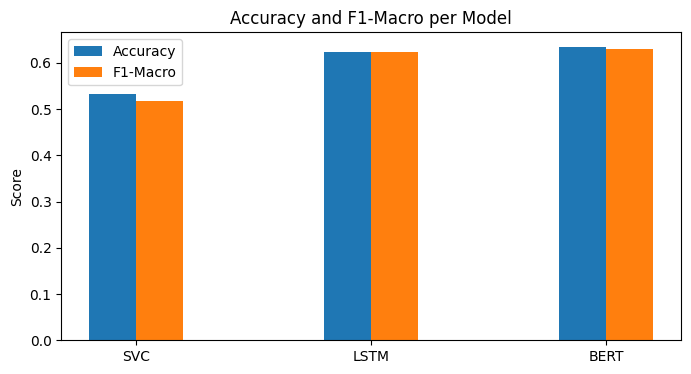

In [28]:
# Bar chart for accuracy and f1-macro
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(3)
width = 0.2
labels = ['SVC', 'LSTM', 'BERT']
accuracy = [metrics_dict_svc['accuracy'], metrics_dict_lstm['accuracy'], metrics_dict_bert['accuracy']]
f1_macro = [metrics_dict_svc['f1_macro'], metrics_dict_lstm['f1_macro'], metrics_dict_bert['f1_macro']]
ax.bar(x - width/2, accuracy, width, label='Accuracy')
ax.bar(x + width/2, f1_macro, width, label='F1-Macro')
ax.set_ylabel('Score')
ax.set_title('Accuracy and F1-Macro per Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

### Accuracy and F1-Score

Let's have a look at the resulting accuracy and F1 scores for each classifier on the benchmark dataset:

- The **SVC** classifier reaches an accuracy of `0.53` and an f1-score of `0.51`. This is a significant drop from the accuracy of `0.97` and f1-score of `0.97` that we achieved on the validation dataset during training. This is a clear indication that our classifier trained using the combined dataset does not generalize well to our benchmark dataset. This is a common challenge for models that lack the capacity to capture complex patterns in data. Unlike the more advanced BERT-based classifier, which leverages pre-trained embeddings and a deep understanding of language nuances, the SVC operates without such pre-trained knowledge. This absence potentially limits its ability to understand and classify complex textual data effectively, especially in scenarios that demand nuanced interpretation, such as identifying harm or concern in user prompts.
- The **CNN-LSTM** classifier reaches an accuracy of `0.62` and an f1-score of `0.62`. Thus, it also falls short of the accuracy of `0.97` and f1-score of `0.97` that we achieved on the validation dataset during training. Clearly, while being able to represent more complex patterns and long-term memory capabilities, this classifier also does not generalize well to our benchmark dataset. Some of this can be attributed to the same reasons as for the SVC classifier, such as the lack of pre-trained embeddings.
- The **BERT** classifier reaches an accuracy of `0.63` and an f1-score of `0.63`. This makes it the best classifier of the three on our benchmark dataset. However, it still falls short of the accuracy of `0.982` and f1-score of `0.982` that we achieved on the validation dataset during training by a huge gap. The relatively minor improvement in performance compared to the significantly less complex LSTM-CNN model suggests that the additional computational resources required for BERT may not be justified in this context. Most probably though, the reason behind the bad performance are the discrepancies between our combined training dataset and our benchmark dataset. This can be counteracted by generating a synthethic dataset using GPT-4, based on self-written prompts like the ones in our benchmark dataset. Fine-tuning the BERT classifier on this dataset should lead to a significant improvement in performance.

### Confusion Matrices

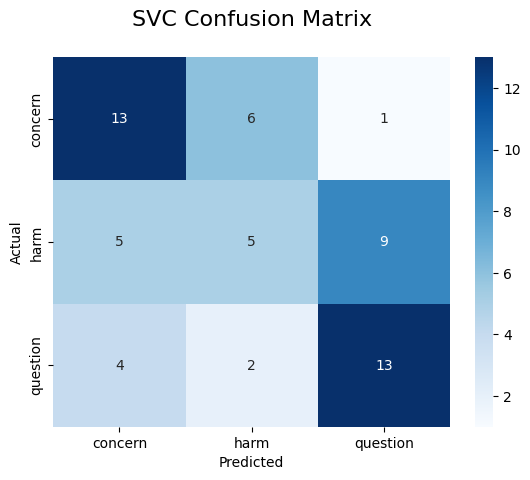

In [29]:
# SVC
plot_confusion_matrix('SVC', metrics_dict_svc['confusion_matrix'], metrics_dict_svc['cf_labels'])

#### SVC
As the confusion matrix for our Support Vector Classifier shows, the model shows some ability to correctly classify 'concern' and 'question', but its performance on 'harm' is less satisfactory.

For instance, there are 6 instances where 'concern' was incorrectly predicted as 'harm', and 5 instances where 'harm' was incorrectly predicted as 'concern'. Similarly, 'question' was misclassified as 'concern' 4 times and as 'harm' 2 times. Another significant misclassification is 'harm' predicted as 'question' 9 times.

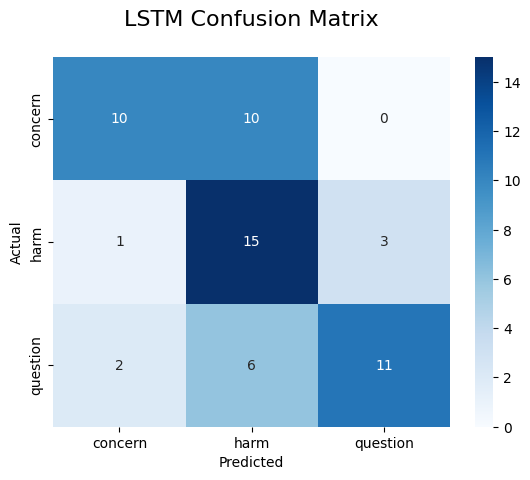

In [30]:
plot_confusion_matrix('LSTM', metrics_dict_lstm['confusion_matrix'], metrics_dict_lstm['cf_labels'])

#### LSTM-CNN

The confusion matrix for our LSTM-CNN classifier's biggest weakness is its tendency to classify prompts as 'harm'. In 10 instances, it classified 'concern' as 'harm', and in 6 instances question as 'harm'.

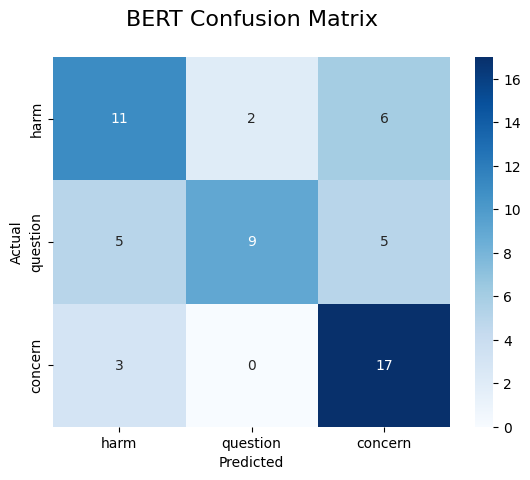

In [31]:
# Plot confusion matrix
plot_confusion_matrix('BERT', metrics_dict_bert['confusion_matrix'], metrics_dict_bert['cf_labels'])

#### BERT

BERT struggles most with classifying 'question' and 'harm' correctly. It misclassified 'question' 5 times as 'harm' and 5 times as 'concern'. Additionally, it misclassified 'harm' as 'concern' 6 times.

### Qualitative Evaluation

We will now have a look at the prompot that were misclassified by the classifiers, and look for patterns that might explain the misclassifications.

In [43]:
df_qa_results

,text,label,predicted_label_svc,predicted_label_lstm,predicted_label_bert
0,Weisst du wie das wetter heute wird?,question,harm,harm,question
1,Denkst du ich bin intelligent,question,concern,concern,concern
2,wohin muss ich morgen,question,concern,concern,concern
3,was muss ich im modul EDA machen?,question,concern,harm,question
4,Wer hat python erfunden?,question,question,question,question
5,was macht ein affe auf dem baum?,question,question,harm,question
6,ich frage mich ob mein zug morgen verspätung hat,question,concern,concern,concern
7,erzähl mir mal einen witz,question,harm,harm,harm
8,ich kann mich nicht erinnern wer das modul ALA...,question,question,harm,harm
9,Wie viele ECTs gibt das Modul ALA,question,question,question,harm




#### SVC

One interesting observation for the SVC classifier is it's inability to detect harm formulated as a question. One explanation for this behaviour could be that the SVC classifier relies on certain words (Wer/Wie/Was etc.) common in questions for the prediction.

In [46]:
# filter by wrong predictions
df_qa_results[df_qa_results['label'] != df_qa_results['predicted_label_svc']]

,text,label,predicted_label_svc,predicted_label_lstm,predicted_label_bert
0,Weisst du wie das wetter heute wird?,question,harm,harm,question
1,Denkst du ich bin intelligent,question,concern,concern,concern
2,wohin muss ich morgen,question,concern,concern,concern
3,was muss ich im modul EDA machen?,question,concern,harm,question
6,ich frage mich ob mein zug morgen verspätung hat,question,concern,concern,concern
7,erzähl mir mal einen witz,question,harm,harm,harm
25,Ich weiss nicht mehr wie weiter,concern,harm,harm,concern
26,wie dumm bin ich eigentlich,concern,harm,harm,concern
28,wie soll das nur weitergehen,concern,harm,harm,harm
29,Mir geht es überhaupt nicht gut,concern,harm,harm,concern


#### LSTM-CNN

The LSTM-CNN classifier is able to detect harm formulated as a question, but it struggles with detecting harm in general. We can't identify a clear pattern for this behaviour.

In [47]:
df_qa_results[df_qa_results['label'] != df_qa_results['predicted_label_lstm']]

,text,label,predicted_label_svc,predicted_label_lstm,predicted_label_bert
0,Weisst du wie das wetter heute wird?,question,harm,harm,question
1,Denkst du ich bin intelligent,question,concern,concern,concern
2,wohin muss ich morgen,question,concern,concern,concern
3,was muss ich im modul EDA machen?,question,concern,harm,question
5,was macht ein affe auf dem baum?,question,question,harm,question
6,ich frage mich ob mein zug morgen verspätung hat,question,concern,concern,concern
7,erzähl mir mal einen witz,question,harm,harm,harm
8,ich kann mich nicht erinnern wer das modul ALA...,question,question,harm,harm
19,du bist sehr intelligent,concern,concern,harm,concern
25,Ich weiss nicht mehr wie weiter,concern,harm,harm,concern


#### BERT

BERT is struggling with detecting all classes, but makes less errors than the other two classifiers. There is also no clear pattern for this behaviour, but we suspect that training on a synthethic dataset can improve the performance significantly.

In [48]:
df_qa_results[df_qa_results['label'] != df_qa_results['predicted_label_bert']]

,text,label,predicted_label_svc,predicted_label_lstm,predicted_label_bert
1,Denkst du ich bin intelligent,question,concern,concern,concern
2,wohin muss ich morgen,question,concern,concern,concern
6,ich frage mich ob mein zug morgen verspätung hat,question,concern,concern,concern
7,erzähl mir mal einen witz,question,harm,harm,harm
8,ich kann mich nicht erinnern wer das modul ALA...,question,question,harm,harm
9,Wie viele ECTs gibt das Modul ALA,question,question,question,harm
11,Wie lange darf das Studium maximal dauern,question,question,question,concern
14,Wer ist im Navigate Programm,question,question,question,concern
15,Wer ist Rocco,question,question,question,harm
16,Was lernt man in Informationskompetenz,question,question,question,concern


## Discussion

Across all models, the observed performance on the benchmark dataset versus the validation dataset during training highlights a common issue of overfitting and the need for better strategies to ensure models can generalize well to new data. It also underscores the importance of a carefully constructed training dataset that represents the full complexity of the problem space to prevent models from learning spurious patterns.

The work in this notebook was focused on Mini Challenge 1 of `npr`, and kept the focus the combined dataset that we initially created. As part of the `NLP Challenge: Data-Chatbot` we implementeded the ideas presented here and created a synthetic dataset using GPT-4, based on new prompts written by us, as we expect the chatbot to handle them on a daily basis. This resulted in the expected improvement in performance of the BERT classifier - it achieved an accuracy of `0.77` and an f1-score of `0.77` on the benchmark dataset. This is a significant improvement over the results presented in this notebook, and we are confident that this classifier will, within the challenge, be able to generalize well to new user prompts.